<a href="https://colab.research.google.com/github/vispute/StackOverflow_semantic_search_engine/blob/master/2_Tag_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 6. Train_test_split - TimeBased : For tag_predictor model

In [ ]:
# 1. Acquiring preprocessed_dataset
df = pd.read_csv('/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/df.csv')

In [ ]:
# defining a function to remove stop_words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add('would')
stop_words.update([chr(c) for c in range(97, 123)])
# stop_words.remove('no'); stop_words.remove('not'); stop_words.remove('nor')

def stopwrd_removal(sent):
  lst = []
  for wrd in sent.split():
    if wrd not in stop_words:
      lst.append(wrd)
  return " ".join(lst)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def text_preprocessor(column):
  """pass any column with Text in it from tbs_df | Note: returns nothing makes inplace changes in tbs_df"""
  # 1. remove html tags, html urls, replace html comparison operators
  text = tbs_df[column].values
  tbs_df[column] = [re.sub('<.*?>', '', i) for i in text]
  tbs_df[column] = tbs_df[column].str.replace('&lt;', '<')\
                                          .str.replace('&gt;', '>')\
                                          .str.replace('&le;', '<=' )\
                                          .str.replace('&ge;', '>=')

  # 2. remove latex i,e., mostly formulas since it's mathematics based dataset
  tbs_df[column] = [re.sub('\$.*?\$', '', i) for i in text]

  # 3. all lowercase 
  tbs_df[column] = tbs_df[column].str.lower()

  # 4. decontractions
  tbs_df[column] = tbs_df[column].str.replace("won't", "will not").str.replace("can\'t", "can not").str.replace("n\'t", " not").str.replace("\'re", " are").str.\
                                                replace("\'s", " is").str.replace("\'d", " would").str.replace("\'ll", " will").str.\
                                                replace("\'t", " not").str.replace("\'ve", " have").str.replace("\'m", " am")

  # 5. remove all special-characters other than alpha-numericals
  tbs_df[column] = [re.sub('\W', ' ', i) for i in text]
  # # remove all digits
  # tbs_df[column] = [re.sub('\d', ' ', i) for i in text]

  # 6. Stop_word removal
  # tbs_df[column] = [stopwrd_removal(i) for i in text]

  # 7. remove all white-space i.e., \n, \t, and extra_spaces
  tbs_df[column] = [re.sub('  +', ' ', i) for i in text]
  tbs_df[column] = tbs_df[column].str.replace("\n", " ").str.replace("\t", " ").str.strip()

In [ ]:
# 1. train_test split
train_set = 0.80
test_set = 1 - train_set

tbs_df = df.sort_values(by = ['UNIX_CreationDate'])
# text_preprocessor('combined_text')
text_data_train = tbs_df['combined_text'].values[:int(df.shape[0]*train_set)]
text_data_test = tbs_df['combined_text'].values[-int(df.shape[0]*test_set):]

tags = tbs_df['tag_1'].str.cat(tbs_df['tag_2'], sep = ' ').str.cat(tbs_df['tag_3'], sep = ' ').str.cat(tbs_df['tag_4'], sep = ' ').str.cat(tbs_df['tag_5'], sep = ' ').tolist()
tags_train = np.array(tags[:int(df.shape[0]*train_set)])
tags_test = np.array(tags[-int(df.shape[0]*test_set):])

del df
text_data_train.shape, text_data_test.shape, tags_train.shape, tags_test.shape

((145666,), (36416,), (145666,), (36416,))

In [ ]:
# 2. make sure all tags in test set are in train set
train_set_tags = np.array([i.split(' ') for i in tags_train])
test_set_tags = np.array([i.split(' ') for i in tags_test])

oob_tags = set(np.unique(test_set_tags)) - set(np.unique(train_set_tags))
len(oob_tags)

0

Text(0.5, 1.0, 'Distribution of test_tags')

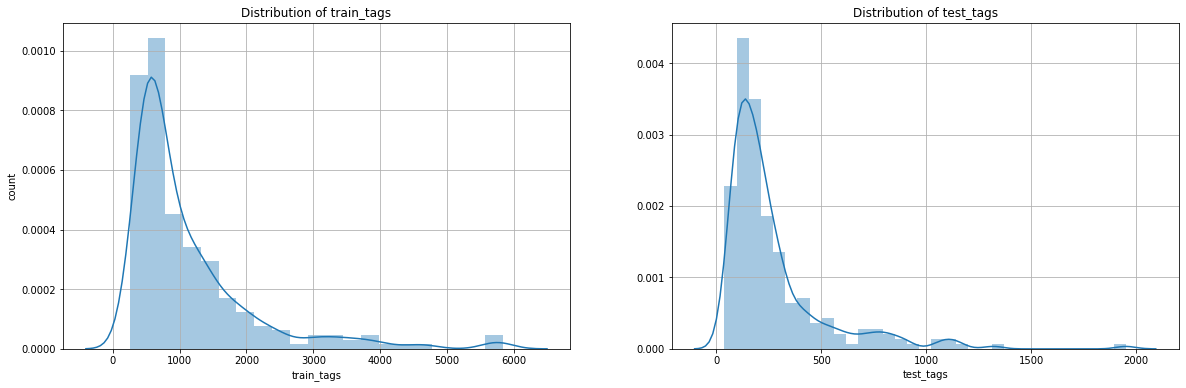

In [ ]:
# 3. checking distribution of train_tags compare to test_tags
# plot train_tags distribution
plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
arr = np.array([j for i in train_set_tags for j in i])
tags, count = np.unique(arr, return_counts = True)
sns.distplot(count[1:])
plt.grid()
plt.xlabel('train_tags')
plt.ylabel('count')
plt.title('Distribution of train_tags')

# distribution of test_tags 
plt.subplot(1,2,2)
arr = np.array([j for i in test_set_tags for j in i])
tags, count = np.unique(arr, return_counts = True)
sns.distplot(count[1:])
plt.plot()
plt.grid()
plt.xlabel('test_tags')
plt.title('Distribution of test_tags')

In [ ]:
# 4. Top 10 tags from train_set
arr = np.array([j for i in train_set_tags for j in i])
tags, count = np.unique(arr, return_counts = True)
d = dict(zip(tags[1:], count[1:]))
sorted(d.items(), key = lambda x: x[1], reverse = True)[:10]

[('<hypothesis_testing>', 5838),
 ('<self_study>', 5744),
 ('<distributions>', 5666),
 ('<logistic>', 4716),
 ('<bayesian>', 4506),
 ('<correlation>', 4110),
 ('<deep_learning>', 3922),
 ('<statistical_significance>', 3763),
 ('<mathematical_statistics>', 3735),
 ('<normal_distribution>', 3521)]

In [ ]:
# 5. Top 10 tags from test_set
arr = np.array([j for i in test_set_tags for j in i])
tags, count = np.unique(arr, return_counts = True)
d = dict(zip(tags[1:], count[1:]))
sorted(d.items(), key = lambda x: x[1], reverse = True)[:10]

[('<deep_learning>', 1952),
 ('<keras>', 1320),
 ('<hypothesis_testing>', 1151),
 ('<mathematical_statistics>', 1133),
 ('<bayesian>', 1114),
 ('<neural_network>', 1067),
 ('<distributions>', 1066),
 ('<reinforcement_learning>', 917),
 ('<tensorflow>', 897),
 ('<logistic>', 868)]

## Notes:
  1. It's always important to check distribution of labels after splitting dataset into train and test. Otherwise model will fail on generalization accuracy.
  2. Here we're doing TimeBased splitting, since I think the nature of questions on the platform is changing over the period of time. Hence it seems best choice to split data.
  3. If we were doing random split then there would not be an issue of label stratification(i.e., almost equal dist of labels).

## Observations:
  1. There are no out_of_bag tags in test_set, i.e., a tag occurs in test_set but not in train_set.
  2. Distribution of train_tags and test_set is almost similar, It implies we're good going.
  3. Top tags_set of both sets are almost similar.

# 7.1 Modelling : Word2Vec embeddings for tag_predictor model
  1. Word2Vec need very large corpus to learn exact word embeddings.
  2. Hence we need to add combine combined_text and preprocessed comments together.
  3. Note: this is only to train w2v model, but we'll be finalizing sentence embedding on 'combined_text' or 'title' only

In [ ]:
# defining a function to remove stop_words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.remove('no'); stop_words.remove('not'); stop_words.remove('nor')

def stopwrd_removal(sent):
  lst = []
  for wrd in sent.split():
    if wrd not in stop_words:
      lst.append(wrd)
  return " ".join(lst)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def text_preprocessor(column):
  """pass any column with Text in it from tbs_df | Note: returns nothing makes inplace changes in tbs_df"""
  # 1. remove html tags, html urls, replace html comparison operators
  text = tbs_df[column].values
  tbs_df[column] = [re.sub('<.*?>', '', i) for i in text]
  tbs_df[column] = tbs_df[column].str.replace('&lt;', '<')\
                                          .str.replace('&gt;', '>')\
                                          .str.replace('&le;', '<=' )\
                                          .str.replace('&ge;', '>=')

  # 2. remove latex i,e., mostly formulas since it's mathematics based dataset
  tbs_df[column] = [re.sub('\$.*?\$', '', i) for i in text]

  # 3. all lowercase 
  tbs_df[column] = tbs_df[column].str.lower()

  # 4. decontractions
  tbs_df[column] = tbs_df[column].str.replace("won't", "will not").str.replace("can\'t", "can not").str.replace("n\'t", " not").str.replace("\'re", " are").str.\
                                                replace("\'s", " is").str.replace("\'d", " would").str.replace("\'ll", " will").str.\
                                                replace("\'t", " not").str.replace("\'ve", " have").str.replace("\'m", " am")

  # 5. remove all special-characters other than alpha-numericals
  tbs_df[column] = [re.sub('\W', ' ', i) for i in text]

  # 6. Stop_word removal
  tbs_df[column] = [stopwrd_removal(i) for i in text]

  # 7. remove all white-space i.e., \n, \t, and extra_spaces
  tbs_df[column] = [re.sub('  +', ' ', i) for i in text]
  tbs_df[column] = tbs_df[column].str.replace("\n", " ").str.replace("\t", " ").str.strip()
  

In [ ]:
# 1. preprocessing comments text
# tbs_df['Comments'].values[:int(tbs_df.shape[0]*train_set)]
tbs_df['Comments'] = tbs_df['Comments'].fillna('')
tbs_df['Comments_1'] = tbs_df['Comments']
text_preprocessor('Comments_1')

In [ ]:
# 2. combining 'combined_text' and 'preprocessed_comments' together
text = tbs_df['combined_text'].values[:int(tbs_df.shape[0]*train_set)]    # only train set
comments = tbs_df['Comments_1'].values[:int(tbs_df.shape[0]*train_set)]   # only train set
all_text_lst =[]

for t, c in zip(text, comments):
    all_text_lst.append(' '.join([t,c]))

del t, c
all_text_lst[:5]

['euler cycles in biconnected components if a graph has a euler cycle do the biconnected components have euler cycles as well homework problem perhaps best try graph may euler cycle doesnt seem follow naturally subset even biconnected one tried comming counter example',
 'can two neighbors in a graph be at the same depth in a dfs tree in an undirected graph can two nodes at an identical distance n from the root of a dfs tree be neighbors in the original graph i am thinking no but i am not sure because of back edges ',
 'unique path in a directed graph i am designing an algorithm for a class that will determine if a directed graph is unique with respect to a vertex such that for any there is at most one path from to i have started by using bfs breadth first search to find the shortest path from v to another vertex u and then running bfs again to see if an alternate path can be found from v to u i think this is too time consuming however does anyone have any hints as to how the solution 

In [ ]:
# 3. creating tokens for each sentence
text_tokens = [i.split() for i in tqdm(all_text_lst)]

In [ ]:
# 4. training w2v model on train set (NOTE: to train w2v model please enable commented code snippet)
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

# # since we are working on small corpus; hence we need to use 'skip-grams' instead of 'CBOW'.
# w2v_model_sg = Word2Vec(text_tokens, size = 100, window = 5, min_count = 3, sg = True, sorted_vocab = True, workers = 2)
# w2v_model_sg.save("/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/word2vec_sg.model")
w2v_model_sg = Word2Vec.load("/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/word2vec_sg.model")
len(w2v_model_sg.wv.vocab)

117779

In [ ]:
w2v_model_sg.most_similar('sigmoid')

[('softmax', 0.8827455043792725),
 ('tanh', 0.882053792476654),
 ('relu', 0.8362493515014648),
 ('activation', 0.815425455570221),
 ('softplus', 0.8108700513839722),
 ('activations', 0.7594355344772339),
 ('rectifier', 0.75226891040802),
 ('layer', 0.7482326030731201),
 ('layer_1', 0.7303577661514282),
 ('relus', 0.7293393611907959)]

**Note : For tag predictor model, we do not remove stop words but for w2v embeddings we have removed stop words for better results**

# 7.2. Modelling : converting i/o to machine readable inputs and outputs
  - Encoder-Decoder tag-predictor model based on 'combined_text'

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Input, Softmax, GRU, LSTM, RNN, Embedding, Dense, RepeatVector, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model

In [ ]:
# 1. creating target tags to train encoder_decoder architecture with LSTM
tar_data_train = np.array([i for i in tags_train])
tar_data_test = np.array([i for i in tags_test])

text_data_train.shape, tar_data_train.shape, text_data_test.shape, tar_data_test.shape

((145666,), (145666,), (36416,), (36416,))

In [ ]:
# 2. tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
max_words = 20000
token_text = Tokenizer(num_words = max_words, filters = '')
token_tar = Tokenizer(num_words = None, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')    # remove '_' from filters

token_text.fit_on_texts(text_data_train)
text_seq_train = token_text.texts_to_sequences(text_data_train)
text_seq_test = token_text.texts_to_sequences(text_data_test)
# 3. bulding vocab
text_vocab = token_text.word_index

token_tar.fit_on_texts(tar_data_train)
tar_seq_train = token_tar.texts_to_sequences(tar_data_train)
tar_seq_test = token_tar.texts_to_sequences(tar_data_test)
# 3. bulding vocab
tar_vocab = token_tar.word_index

In [ ]:
# saving the tokenizers to use it at 'final_pipeline'
import pickle
with open('/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/tag_predictor_tokenizer.pickle', 'wb') as handle:
    pickle.dump(token_text, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/tag_predictor_token_tar.pickle', 'wb') as handle:
    pickle.dump(token_tar, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# 3. building vocab
print('Total no.of words in TEXT vocab =', len(text_vocab))
print('Total no.of words in TARGET vocab =', len(tar_vocab))

Total no.of words in TEXT vocab = 378788
Total no.of words in TARGET vocab = 242


In [ ]:
# 4.1. padding : max lengths
from tensorflow.keras.preprocessing.sequence import pad_sequences
text_max_len = max([len(i) for  i in text_seq_train])
tar_max_len = max([len(i) for  i in tar_seq_train])
print('MAX seq_len in text sentences = {}\nMAX seq_len in TARGET sequences = {}'.format(text_max_len, tar_max_len))

MAX seq_len in text sentences = 8935
MAX seq_len in TARGET sequences = 5


In [ ]:
# 4.2. padding : setting up sequence max_len threshold using percentile method (for padding the seq)
len_lst = [len(i) for  i in text_seq_train]
for i in np.arange(80, 100, 1):
  print('percentile = {} | seq_len = {} | no.of datapts NOT covered = {}'.format(round(i, 2), round(np.percentile(len_lst, i)), round(len(len_lst) - (i*len(len_lst)*0.01))))

percentile = 80 | seq_len = 233.0 | no.of datapts NOT covered = 29133.0
percentile = 81 | seq_len = 239.0 | no.of datapts NOT covered = 27677.0
percentile = 82 | seq_len = 245.0 | no.of datapts NOT covered = 26220.0
percentile = 83 | seq_len = 252.0 | no.of datapts NOT covered = 24763.0
percentile = 84 | seq_len = 259.0 | no.of datapts NOT covered = 23307.0
percentile = 85 | seq_len = 267.0 | no.of datapts NOT covered = 21850.0
percentile = 86 | seq_len = 276.0 | no.of datapts NOT covered = 20393.0
percentile = 87 | seq_len = 285.0 | no.of datapts NOT covered = 18937.0
percentile = 88 | seq_len = 295.0 | no.of datapts NOT covered = 17480.0
percentile = 89 | seq_len = 306.0 | no.of datapts NOT covered = 16023.0
percentile = 90 | seq_len = 318.0 | no.of datapts NOT covered = 14567.0
percentile = 91 | seq_len = 332.0 | no.of datapts NOT covered = 13110.0
percentile = 92 | seq_len = 349.0 | no.of datapts NOT covered = 11653.0
percentile = 93 | seq_len = 366.0 | no.of datapts NOT covered = 

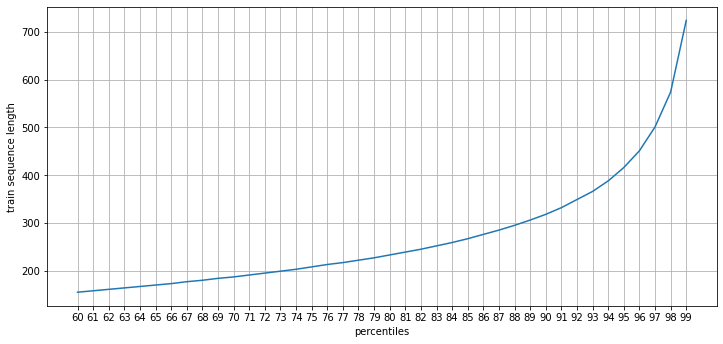

In [ ]:
# 4.3. padding : setting up sequence max_len threshold using elbow_method
lst = []
lst_i = []
for i in np.arange(60, 100, 1):
  lst_i.append(round(i, 2))
  lst.append(round(np.percentile(len_lst, i)))
plt.figure(figsize= (12, 5.5))
plt.plot(lst)
plt.grid()
plt.xlabel('percentiles')
plt.ylabel('train sequence length')
plt.xticks(ticks = range(0, 40), labels = lst_i)
plt.show()

In [ ]:
# 4.4. padding : padding the train and test sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
text_seq_train = pad_sequences(text_seq_train, maxlen = 250, padding = 'post')
tar_seq_train = pad_sequences(tar_seq_train, maxlen = tar_max_len, padding = 'post')

text_seq_test = pad_sequences(text_seq_test, maxlen = 250, padding = 'post')
tar_seq_test = pad_sequences(tar_seq_test, maxlen = tar_max_len, padding = 'post')

text_seq_train.shape, tar_seq_train.shape, text_seq_test.shape, tar_seq_test.shape

((145666, 250), (145666, 5), (36416, 250), (36416, 5))

In [ ]:
# 4.5. padding : replacing zero padding with previous tag
for i in range(tar_seq_train.shape[1]):
  if i != 0:
    zero_idx = np.where(tar_seq_train[:, i] == 0)
    tar_seq_train[zero_idx, i] = tar_seq_train[zero_idx, i-1]

for i in range(tar_seq_test.shape[1]):
  if i != 0:
    zero_idx = np.where(tar_seq_test[:, i] == 0)
    tar_seq_test[zero_idx, i] = tar_seq_test[zero_idx, i-1]

# NOTE:
  1. In a search engine nobody is going to place a query consisting with 300, 400, 500 words but to cover almost all kind of data I chose to go with 250 words.
  2. For tags feature, I experimented with lots of schemes like 
    i. output layer = sigmoid units and loss = 'binary_crossentropy'. In this scheme problem is - each datapoint has varying no.of tags.
    ii. zero padding with tags label: zeros starts dominating model like crazy. since 3rd, 4th, 5th column will have lots of zeros than any other single tag.
  3. Hence I decided to go with copying previous column tag, so that no single tag should dominate. This method worked in this scenerio

In [ ]:
# 5. balancing the dataset
from sklearn.utils.class_weight import compute_sample_weight
columns = 5
sample_wt_mat = np.zeros((len(tar_seq_train), columns))
for col in range(columns):
  y = tar_seq_train[:, col]
  sample_wt = compute_sample_weight(class_weight= 'balanced', y = y)
  sample_wt_mat[:, col] = sample_wt
sample_wt_mat.shape

(145666, 5)

In [ ]:
# 6. converting target sequence to categorical form
from tensorflow.keras.utils import to_categorical
target_seq_train = to_categorical(tar_seq_train)
target_seq_test = to_categorical(tar_seq_test)

target_seq_train.shape, target_seq_test.shape

((145666, 5, 243), (36416, 5, 243))

In [ ]:
# 7. Embedding Matrix with Word2Vec representations
embedding_matrix = np.random.normal(loc = 0, scale = 0.15, size = (max_words+1, 100))
w2v_vocab = set(w2v_model_sg.wv.vocab)
for word, i in text_vocab.items():
    if i <= max_words and word in w2v_vocab:
      vector = w2v_model_sg[word]
    # if vector is not None:
      embedding_matrix[i] = vector
embedding_matrix.shape

(20001, 100)

# 7.3. Modelling :  Constructing a model

In [ ]:
# 8. Creating freezed 'Embedding layer'
text_embedding_layer = Embedding(input_dim = max_words+1, output_dim= 100,  weights = [embedding_matrix],
                               mask_zero = True, trainable = False, name = 'text_embed')

In [ ]:
# 9. Constructing a model
tf.keras.backend.clear_session()

enc_inputs = Input(name = 'text_seq', shape = (250,))
enc_embed = text_embedding_layer(enc_inputs)
encoder = Bidirectional(GRU(name = 'ENCODER', units = 128, dropout = 0.2))

enc_out = encoder(enc_embed)

dec_lstm = GRU(name = 'DECODER', units = 256, dropout = 0.2, return_sequences= True, return_state= True)

repeat = RepeatVector(5)(enc_out)
dec_out, dec_hidden = dec_lstm(repeat)

dec_dense = Dense(units = len(tar_vocab)+1, activation = 'softmax')
out = dec_dense(dec_out)

model = Model(inputs = enc_inputs, outputs = out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_seq (InputLayer)        [(None, 250)]             0         
_________________________________________________________________
text_embed (Embedding)       (None, 250, 100)          2000100   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               176640    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 256)            0         
_________________________________________________________________
DECODER (GRU)                [(None, 5, 256), (None, 2 394752    
_________________________________________________________________
dense (Dense)                (None, 5, 243)            62451     
Total params: 2,633,943
Trainable params: 633,843
Non-trainable params: 2,000,100
_____________________________________________

In [ ]:
# Defining callbacks
# !rm -r '/content/saved models'
!mkdir '/content/saved models'
!mkdir '/content/logs/'

# tensorboard callback
import datetime
log_dir="logs/" + datetime.datetime.now().strftime("%Y-%m-%d %H_%M_%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq=1, write_graph=True, write_grads=True)

# Custom test_data evaluator
class custom_val_loss(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.x, self.y = validation_data
    
    def on_train_begin(self, logs={}):
        self.loss_history = {'val_loss' :[], 'val_auc' : [], 'val_pr': [], 'val_re' : [], 'val_f1' : []}
        
    def on_epoch_end(self, epoch, logs={}):
        self.epoch = epoch
        # 1. Test_set evaluation
        print('\nTest :')
        val_loss, val_auc, val_pr, val_re = self.model.evaluate(x = self.x, y = self.y, batch_size = 256)
        val_loss, val_auc, val_pr, val_re = round(val_loss,5), round(val_auc,5), round(val_pr,5), round(val_re,5)
        val_f1 = round(2*((val_pr * val_re)/(val_pr + val_re)), 5)

        self.loss_history['val_loss'].append(val_loss)
        self.loss_history['val_auc'].append(val_auc)
        self.loss_history['val_pr'].append(val_pr)
        self.loss_history['val_re'].append(val_re)
        self.loss_history['val_f1'].append(val_f1)
        prev_epoch_lr  = tf.keras.backend.eval(self.model.optimizer.lr)
        print("validation_f1 : {} | Learning_Rate : {}".format(val_f1, round(prev_epoch_lr, 6)))

        # 2. Scheduling learning-rate if validation loss is not improving
        prev_epoch_lr  = tf.keras.backend.eval(self.model.optimizer.lr)

        if len(self.loss_history['val_loss']) > 3:
          if self.loss_history['val_loss'][-1] > self.loss_history['val_loss'][-2]:
            self.model.optimizer.lr = np.sqrt(0.1) * prev_epoch_lr
            print(' Learning_rate_dropped :', round(tf.keras.backend.eval(self.model.optimizer.lr), 6))

        # 3. Saving model on val_loss improvement
        if len(self.loss_history['val_loss']) > 1:
          if self.loss_history['val_loss'][-1] < self.loss_history['val_loss'][-2]:
            path = '/content/saved models/weights--{:03d}--{:.4f}.hdf5'.format(self.epoch, val_loss)
            self.model.save(path)
            print('model saved to :', path)

custom_evaluator = custom_val_loss(validation_data = [text_seq_test, target_seq_test])

mkdir: cannot create directory ‘/content/saved models’: File exists
mkdir: cannot create directory ‘/content/logs/’: File exists


In [ ]:
# GRU : training a model
from tensorflow.keras.optimizers import Adam, RMSprop
tf.keras.backend.clear_session()
opt = Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt,  metrics = ['AUC', 'Precision', 'Recall'], sample_weight_mode = 'temporal')
history = model.fit(text_seq_train, target_seq_train, batch_size = 128, epochs = 20, callbacks=[custom_evaluator, tensorboard_callback], sample_weight = sample_wt_mat)

Epoch 1/20
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1138/1139 [============================>.] - ETA: 0s - loss: 3.5792 - auc: 0.8688 - precision: 0.5890 - recall: 0.0277
Test :
143/143 [==============================] - 17s 117ms/step - loss: 3.0115 - auc: 0.9181 - precision: 0.6036 - recall: 0.0789
validation_f1 : 0.13959 | Learning_Rate : 0.0010000000474974513
1139/1139 [==============================] - 191s 168ms/step - loss: 3.5792 - auc: 0.8688 - precision: 0.5890 - recall: 0.0277
Epoch 2/20
1139/1139 [==============================] - ETA: 0s - loss: 2.7299 - auc: 0.9215 - precision: 0.5826 - recall: 0.1083
Test :
143/143 [==============================] - 17s 116ms/step - loss: 2.7712 - auc: 0.9259 - precision: 0.5769 - recall: 0.1417
validation_f1 : 0.22747 | Learning_Rate : 0.0010000000474974513
model saved to : /content/saved models7/weights--001--2.7712.hdf5
1139/1139 [==============================] - 188s 165ms/step - loss: 2.7299 

In [ ]:
!cp '/content/saved models7/weights--019--2.4615.hdf5' '/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/'

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir '/content/logs/'

<IPython.core.display.Javascript object>

### 7.3.2. Inference - Testing architecture - ONLY ON 'TITLE'

In [ ]:
def text_preprocessor(column):
  """pass any column with Text in it from tbs_df | Note: returns nothing makes inplace changes in tbs_df"""
  # 1. remove html tags, html urls, replace html comparison operators
  text = tbs_df[column].values
  tbs_df[column] = [re.sub('<.*?>', '', i) for i in text]
  tbs_df[column] = tbs_df[column].str.replace('&lt;', '<')\
                                          .str.replace('&gt;', '>')\
                                          .str.replace('&le;', '<=' )\
                                          .str.replace('&ge;', '>=')

  # 2. remove latex i,e., mostly formulas since it's mathematics based dataset
  tbs_df[column] = [re.sub('\$.*?\$', '', i) for i in text]

  # 3. all lowercase 
  tbs_df[column] = tbs_df[column].str.lower()

  # 4. decontractions
  tbs_df[column] = tbs_df[column].str.replace("won't", "will not").str.replace("can\'t", "can not").str.replace("n\'t", " not").str.replace("\'re", " are").str.\
                                                replace("\'s", " is").str.replace("\'d", " would").str.replace("\'ll", " will").str.\
                                                replace("\'t", " not").str.replace("\'ve", " have").str.replace("\'m", " am")

  # 5. remove all special-characters other than alpha-numericals
  tbs_df[column] = [re.sub('\W', ' ', i) for i in text]

  # # 6. Stop_word removal
  # tbs_df[column] = [stopwrd_removal(i) for i in text]

  # 7. remove all white-space i.e., \n, \t, and extra_spaces
  tbs_df[column] = tbs_df[column].str.replace("\n", " ").str.replace("\t", " ").str.rstrip()
  tbs_df[column] = [re.sub('  +', ' ', i) for i in text]

#### Train_test_split - TimeBased : For tag_predictor model

In [ ]:
# Acquiring preprocessed_dataset
df = pd.read_csv('/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/df.csv')

In [ ]:
# 1. train_test split
train_set = 0.80
test_set = 1 - train_set

tbs_df = df.sort_values(by = ['UNIX_CreationDate'])

# text preprocessing on 'Title'
tbs_df['Title_1'] = tbs_df['Title']
text_preprocessor('Title_1')

text_data_train = tbs_df['Title'].values[:int(df.shape[0]*train_set)]
text_data_test = tbs_df['Title'].values[-int(df.shape[0]*test_set):]

tags = tbs_df['tag_1'].str.cat(tbs_df['tag_2'], sep = ' ').str.cat(tbs_df['tag_3'], sep = ' ').str.cat(tbs_df['tag_4'], sep = ' ').str.cat(tbs_df['tag_5'], sep = ' ').tolist()
tags_train = np.array(tags[:int(df.shape[0]*train_set)])
tags_test = np.array(tags[-int(df.shape[0]*test_set):])

del df
text_data_train.shape, text_data_test.shape, tags_train.shape, tags_test.shape

((145666,), (36416,), (145666,), (36416,))

In [ ]:
text_seq_test = token_text.texts_to_sequences(text_data_test)
text_seq_test = pad_sequences(text_seq_test, maxlen = 250, padding = 'post')

In [ ]:
# !cp '/content/saved models/weights--008--1.3756.hdf5' 'content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/'
model.load_weights('/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/weights--019--2.4615.hdf5')
# model.load_weights('/content/saved models7/weights--008--2.3871.hdf5')

**change test datapoint index below :**

In [ ]:
dp = 18000 # datapoint                 600, 1200, 6000, 12000, 18000, 24000, 30000, 36000
text_wrd_dict = text_vocab
tar_wrd_dict = tar_vocab
text_wrd_dict_reverse = {v:k for k, v in text_vocab.items()}
tags_wrd_dict_reverse = {v:k for k, v in tar_vocab.items()}

input_sequence = " ".join([text_wrd_dict_reverse[i] for i in text_seq_test[dp] if i != 0])
output_sequence = set([tags_wrd_dict_reverse[i] for i in tar_seq_test[dp] if i != 0])
tar_seq_test[dp], input_sequence, output_sequence

(array([37, 37, 37, 37, 37], dtype=int32),
 'r chi square test with degrees of freedom',
 {'chi_squared'})

**just run below code snippent to get results :**

In [ ]:
x = text_seq_test[dp].reshape(1, -1)
model_output = model.predict(x)
tar_wrd_lst = []
for i in model_output[0]:
  tar_wrd_idx = np.argmax(i)
  tar_wrd = tags_wrd_dict_reverse[tar_wrd_idx]
  tar_wrd_lst.append(tar_wrd)
  
  target_sequence = set(tar_wrd_lst)

print('Query : {} \nTags : {}'.format(input_sequence, target_sequence))

Query : r chi square test with degrees of freedom 
Tags : {'chi_squared'}


# 7.4. Predicting whole dataset :

In [ ]:
# 1. Loading saved tokenizers
import pickle
handle = open('/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/tag_predictor_tokenizer.pickle', 'rb')
token_text = pickle.load(handle)

handle = open('/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/tag_predictor_token_tar.pickle', 'rb')
token_tar = pickle.load(handle)

text_vocab = token_text.word_index
tar_vocab = token_tar.word_index

# 2. loading model weights
model.load_weights('/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/weights--019--2.4615.hdf5')

In [ ]:
# defining a function to remove stop_words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add('would')
stop_words.update([chr(c) for c in range(97, 123)])
# stop_words.remove('no'); stop_words.remove('not'); stop_words.remove('nor')

def stopwrd_removal(sent):
  lst = []
  for wrd in sent.split():
    if wrd not in stop_words:
      lst.append(wrd)
  return " ".join(lst)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# 3. input text preprocessor
def text_preprocessor(corpus, stop_word = False, remove_digits = False):
  clean_corpus = []
  for doc in corpus:
    # 1. remove html tags, html urls, replace html comparison operators
    clean_str = re.sub('<.*?>', '', doc)
    clean_str = clean_str.replace('&lt;', '<')\
                .replace('&gt;', '>')\
                .replace('&le;', '<=' )\
                .replace('&ge;', '>=')

    # 2. remove latex i,e., mostly formulas since it's mathematics based dataset
    clean_str = re.sub('\$.*?\$', '', clean_str)

    # 3. all lowercase 
    clean_str = clean_str.lower()

    # 4. decontractions
    clean_str = clean_str.replace("won't", "will not").replace("can\'t", "can not").replace("n\'t", " not").replace("\'re", " are").\
                                                  replace("\'s", " is").replace("\'d", " would").replace("\'ll", " will").\
                                                  replace("\'t", " not").replace("\'ve", " have").replace("\'m", " am")

    # 5. remove all special-characters other than alpha-numericals
    clean_str = re.sub('\W', ' ', clean_str)
    if remove_digits == True:
      clean_str = re.sub('\d', ' ', clean_str)

    # 6. Stop_word removal
    if stop_word == True:
      clean_str = stopwrd_removal(clean_str)

    # 7. remove all white-space i.e., \n, \t, and extra_spaces
    clean_str = re.sub('  +', ' ', clean_str)
    clean_str = clean_str.replace("\n", " ").replace("\t", " ").strip()

    clean_corpus.append(clean_str)

  return clean_corpus

def padded_sequence(clean_corpus):
    # 8. converting words into tokens (int)
    tokens = token_text.texts_to_sequences(clean_corpus)

    # 9. padding the sequence
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    sequence = pad_sequences(tokens, maxlen = 250, padding = 'post')

    return sequence

In [ ]:
tar_vocab_reverse = {v:k for k,v in tar_vocab.items()}
def final_tag_prediction(corpus):
  """
  1. Text preprocessing on corpus
  2. Convert clean corpus to padded sequence
  3. Passes sequence through model and model generates output
  4. Converts model output into tags list of tags
  """
  # 10. model prediction
  clean_corpus = text_preprocessor(corpus,  stop_word = False, remove_digits = False)
  sequence = padded_sequence(clean_corpus)

  # dataset contain some sequences with all zeros after preprocessing and tokenizing.
  # Hence removing sequences with all zeros in the corpus
  all_zero_idx = [i for i in range(len(sequence)) if (sequence[i] == np.zeros(250)).all()]
  sequence = np.delete(sequence, all_zero_idx, axis = 0)

  model_out = model.predict(sequence)

  # 11. converting model prediction to human readable tags
  final_lst = []
  for dp in model_out:
    tar_wrd_idx_lst = []
    for time_step in dp:
      tar_wrd_idx = np.argmax(time_step)
      tar_wrd = ('<' + tar_vocab_reverse[tar_wrd_idx] + '>')
      tar_wrd_idx_lst.append(tar_wrd)
      lst = list(set(tar_wrd_idx_lst))
    final_lst.append(lst)
  
  return final_lst, all_zero_idx

In [ ]:
%%time
# 12. predicting whole dataset
corpus = tbs_df['Title'].tolist()      # provide any string inside list
tags_pred, all_zero_idx = final_tag_prediction(corpus)
print(len(all_zero_idx))

0
CPU times: user 44.7 s, sys: 4.81 s, total: 49.5 s
Wall time: 36.7 s


In [ ]:
# 13. removing datapoints with all zeros in input sequences
tbs_df['index'] = range(len(tbs_df))
tbs_df = tbs_df.reset_index(drop= True)
tbs_df = tbs_df.drop(index = all_zero_idx, axis = 1)
tbs_df = tbs_df.reset_index(drop= True)

In [ ]:
# 14. creating new colummns with predicted tags
print('maximum no.of tags one datapoint can have:', max([len(i) for i in tags_pred]))
tbs_df = pd.concat([tbs_df, pd.DataFrame(tags_pred, columns = ['tag_pred1', 'tag_pred2', 'tag_pred3', 'tag_pred4', 'tag_pred5'])], axis = 1)
tbs_df = tbs_df.fillna('-')

maximum no.of tags one datapoint can have: 5


In [ ]:
tbs_df.to_csv('/content/drive/My Drive/AAIC Course/Personal case study - StackOverflow/tbs_df.csv', index = False)

In [ ]:
tbs_df.head()

,Title,Body,Tags,CreationDate,LastActivityDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Comments,index_left,tag_1,tag_2,tag_3,tag_4,tag_5,index,combined_text,sentiment_comb,subjectivity_comb,sentiment_comments,subjectivity_comments,UNIX_CreationDate,Title_1,tag_pred1,tag_pred2,tag_pred3,tag_pred4,tag_pred5
0,Euler cycles in biconnected components,"<p>If a graph has a Euler cycle, do the biconn...",<graphs><eulerian_paths>,2008-11-25T14:59:38.553,2012-09-24T13:48:36.543,9,334,1,1,0,"If this is a homework problem, perhaps its bes...",6903,<graphs>,-,-,-,-,0,euler cycles in biconnected components if a gr...,0.000000,0.000000,0.566667,0.566667,1.227625e+09,euler cycles in biconnected components,<graphs>,-,-,-,-
1,Can two neighbors in a graph be at the same de...,"<p>In an undirected graph, can two nodes at an...",<graphs><graph_traversal>,2008-11-28T20:38:14.300,2012-09-24T13:48:52.410,6,138,3,0,0,-,6904,<graphs>,-,-,-,-,1,can two neighbors in a graph be at the same de...,0.031250,0.440972,0.000000,0.000000,1.227905e+09,can two neighbors in a graph be at the same de...,<trees>,-,-,-,-
2,Unique path in a directed graph,<p>I'm designing an algorithm for a class that...,<graphs><shortest_path><graph_traversal>,2008-12-08T22:07:40.493,2012-12-13T02:10:52.957,9,2138,3,0,1,-,6905,<graphs>,-,-,-,-,2,unique path in a directed graph i am designing...,0.250000,0.555556,0.000000,0.000000,1.228774e+09,unique path in a directed graph,<graphs>,-,-,-,-
3,What do you call an average that does not incl...,<p>What do you call an average that does not i...,<mean><outliers><terminology><average>,2009-02-02T14:21:12.103,2020-01-12T17:40:44.297,70,108331,15,2,15,https://sciencing.com/calculate-outliers-52014...,67764,<mean>,<outliers>,<terminology>,-,-,3,what do you call an average that does not incl...,-0.150000,0.400000,-0.050000,0.547778,1.233584e+09,what do you call an average that does not incl...,<outliers>,-,-,-,-
4,Correcting for outliers in a running average,<p>We have a daemon that reads in data from so...,<outliers><average><cooks_distance>,2009-04-12T07:24:17.007,2017-03-01T14:05:17.163,14,7007,7,6,1,During bootstrapping provide 64 data points to...,67765,<outliers>,-,-,-,-,4,correcting for outliers in a running average w...,0.014588,0.443397,0.082625,0.416241,1.239521e+09,correcting for outliers in a running average,<outliers>,-,-,-,-
